# Importing necessary packages

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
import numpy as np
import nltk
import re
import spacy
from textblob import TextBlob
from wordcloud import WordCloud

# Loading dataset

In [4]:
# Load Business Data
business_data = []
with open("E:\Yelp JSON\yelp_dataset\yelp_academic_dataset_business.json", "r", encoding="utf-8") as file:
    for line in file:
        try:
            business_data.append(json.loads(line))
        except json.JSONDecodeError as e:
            print(f"Skipping malformed line due to error: {e}")

businesses = pd.DataFrame(business_data)

<>:3: SyntaxWarning: invalid escape sequence '\Y'
<>:3: SyntaxWarning: invalid escape sequence '\Y'
C:\Users\Admin\AppData\Local\Temp\ipykernel_28100\3346873701.py:3: SyntaxWarning: invalid escape sequence '\Y'
  with open("E:\Yelp JSON\yelp_dataset\yelp_academic_dataset_business.json", "r", encoding="utf-8") as file:


In [6]:
data1 = []
bad_lines = 0

file_path = r"E:\Yelp JSON\yelp_dataset\yelp_academic_dataset_review.json"

with open(file_path, 'r', encoding='utf-8') as f:
    for i, line in enumerate(f):
        try:
            data1.append(json.loads(line))
        except json.JSONDecodeError as e:
            print(f"Skipping line {i} due to error: {e}")
            bad_lines += 1

print(f"Successfully loaded {len(data1)} lines. Skipped {bad_lines} bad lines.")
reviews = pd.DataFrame(data1)

Skipping line 1612228 due to error: Unterminated string starting at: line 1 column 162 (char 161)
Successfully loaded 1612228 lines. Skipped 1 bad lines.


# Displaying first 3 rows of both business and review dataset

In [7]:
businesses.head(3)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."


In [8]:
reviews.head(3)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30


# Cleaned review dataset

In [9]:
reviews.to_json("cleaned_reviews.json", orient="records", lines=True)
review=pd.read_json(r"E:\cleaned_reviews.json",lines=True)

In [10]:
review.head(2)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18


# Two datasets are merged based on business id

In [11]:
merged_df = pd.merge(review, businesses, on='business_id', how='inner')

# First four rows are viewed

In [12]:
merged_df.head(4)

,review_id,user_id,business_id,stars_x,useful,funny,cool,text,date,name,...,state,postal_code,latitude,longitude,stars_y,review_count,is_open,attributes,categories,hours
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,Turning Point of North Wales,...,PA,19454,40.210196,-75.223639,3.0,169,1,"{'NoiseLevel': 'u'average'', 'HasTV': 'False',...","Restaurants, Breakfast & Brunch, Food, Juice B...","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'..."
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18,Body Cycle Spinning Studio,...,PA,19119,39.952103,-75.172753,5.0,144,0,"{'BusinessAcceptsCreditCards': 'True', 'GoodFo...","Active Life, Cycling Classes, Trainers, Gyms, ...","{'Monday': '6:30-20:30', 'Tuesday': '6:30-20:3..."
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30,Kettle Restaurant,...,AZ,85713,32.207233,-110.980864,3.5,47,1,"{'RestaurantsReservations': 'True', 'BusinessP...","Restaurants, Breakfast & Brunch",None
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,Zaika,...,PA,19114,40.079848,-75.025080,4.0,181,1,"{'Caters': 'True', 'Ambience': '{'romantic': F...","Halal, Pakistani, Restaurants, Indian","{'Tuesday': '11:0-21:0', 'Wednesday': '11:0-21..."


# Shape and column of the merged dataset is displayed

In [13]:
print("Merged yolo dataset Shape:",merged_df.shape)

Merged yolo dataset Shape: (1612228, 22)


In [14]:
merged_df.columns

Index(['review_id', 'user_id', 'business_id', 'stars_x', 'useful', 'funny',
       'cool', 'text', 'date', 'name', 'address', 'city', 'state',
       'postal_code', 'latitude', 'longitude', 'stars_y', 'review_count',
       'is_open', 'attributes', 'categories', 'hours'],
      dtype='object')

# Datatypes and null values are checked

In [15]:
merged_df.dtypes

review_id               object
user_id                 object
business_id             object
stars_x                  int64
useful                   int64
funny                    int64
cool                     int64
text                    object
date            datetime64[ns]
name                    object
address                 object
city                    object
state                   object
postal_code             object
latitude               float64
longitude              float64
stars_y                float64
review_count             int64
is_open                  int64
attributes              object
categories              object
hours                   object
dtype: object

In [16]:
merged_df.isnull().sum()

review_id           0
user_id             0
business_id         0
stars_x             0
useful              0
funny               0
cool                0
text                0
date                0
name                0
address             0
city                0
state               0
postal_code         0
latitude            0
longitude           0
stars_y             0
review_count        0
is_open             0
attributes      39593
categories        152
hours           90959
dtype: int64

Data cleaning to remove null values

In [17]:
merged_df['hours'] = merged_df['hours'].fillna('unknown')
merged_df['attributes'] = merged_df['attributes'].fillna('{}')
merged_df['categories'] = merged_df['categories'].fillna('unknown')

In [18]:
merged_df.isnull().sum()

review_id       0
user_id         0
business_id     0
stars_x         0
useful          0
funny           0
cool            0
text            0
date            0
name            0
address         0
city            0
state           0
postal_code     0
latitude        0
longitude       0
stars_y         0
review_count    0
is_open         0
attributes      0
categories      0
hours           0
dtype: int64

Describe statistics of the merged dataset

In [19]:
merged_df.describe()

,stars_x,useful,funny,cool,date,latitude,longitude,stars_y,review_count,is_open
count,1.612228e+06,1.612228e+06,1.612228e+06,1.612228e+06,1612228,1.612228e+06,1.612228e+06,1.612228e+06,1.612228e+06,1.612228e+06
mean,3.769188e+00,1.146299e+00,3.201563e-01,4.810517e-01,2016-10-25 03:43:06.642254848,3.605820e+01,-8.950185e+01,3.763533e+00,3.436885e+02,8.255104e-01
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2005-03-01 16:57:17,2.755513e+01,-1.200951e+02,1.000000e+00,5.000000e+00,0.000000e+00
25%,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2014-11-09 21:18:36.249999872,2.997543e+01,-9.029462e+01,3.500000e+00,4.600000e+01,1.000000e+00
50%,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2017-02-26 13:19:03.500000,3.861702e+01,-8.619715e+01,4.000000e+00,1.410000e+02,1.000000e+00
75%,5.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2019-02-18 23:26:45.249999872,3.994557e+01,-7.540065e+01,4.500000e+00,3.650000e+02,1.000000e+00
max,5.000000e+00,5.390000e+02,2.840000e+02,2.010000e+02,2022-01-19 19:47:59,5.364846e+01,-7.465857e+01,5.000000e+00,5.070000e+03,1.000000e+00
std,1.458551e+00,2.918509e+00,1.591784e+00,1.949834e+00,NaN,5.323797e+00,1.476030e+01,7.381736e-01,5.823979e+02,3.795301e-01


# Preprocess text function

In [22]:
def pre_process(text):
    text = text.apply(lambda x: x.lower() if isinstance(x, str) else "") 
    text = text.apply(lambda x: re.sub(r'[^\w\s]', '', x)) 
    return text

# Entity extraction

In [23]:
def extract_entities(text):
    nlp=spacy.load("en_core_web_sm")
    doc=nlp(text)
    entities=[(ent.text,ent.label_) for ent in doc.ents]
    return entities

# Sentiment Analysis

In [24]:
def analyze_sentiment(text):
    blob=TextBlob(text)
    sentiment_score=blob.sentiment.polarity
    if sentiment_score>0:
        sentiment_label='positive'
    elif sentiment_score<0:
         sentiment_label='negative'
    else:
         sentiment_label='neutral'
    return {"label":sentiment_label,"score":sentiment_score}

# Wordcloud

In [25]:
def wordcloud(text):
    wordcloud=WordCloud().generate(text)
    plt.figure(figsize=(10,4))
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Insight extraction

In [26]:
def extract_insights(entities, sentiment_result):
    insights = {
        "Key entities:": entities,
        "Overall sentiment:": sentiment_result["label"],
        "Sentiment Score:": sentiment_result["score"]
    }
    return insights


# Demo for sentiment analysis

In [32]:
merged_df=merged_df[:100000] #due to memory constraints

In [33]:
merged_df=merged_df[:100000]
merged_df.shape

(100000, 23)

In [34]:
merged_df=merged_df[:100000]

In [44]:
# first 100000 samples are taken due to memory constraints
merged_df=merged_df[:5000]
text_preprocessed=text_preprocessed[:5000]

Text preprocessed: 0       if you decide to eat here just be aware it is ...
1       ive taken a lot of spin classes over the years...
2       family diner had the buffet eclectic assortmen...
3       wow  yummy different  delicious   our favorite...
4       cute interior and owner  gave us tour of upcom...
                              ...                        
4995    after trying the pizza here on halloween night...
4996    went here today with my family and i must say ...
4997    my room was disgusting the odor when i walked ...
4998    first time my girlfriend and i came here and i...
4999    by far the worst effort at chain mexican food ...
Name: text, Length: 5000, dtype: object
------------------------------------------------------------------------------------------------------------------
entities: [('about 2 hours', 'TIME')]
------------------------------------------------------------------------------------------------------------------
Sentiment: {'label': 'positive', 's

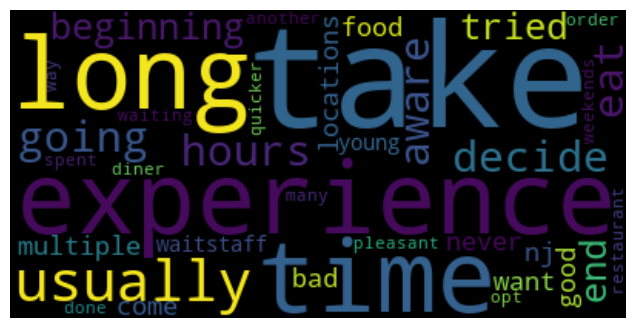

None
------------------------------------------------------------------------------------------------------------------
Insights:
{'Key entities:': [('about 2 hours', 'TIME')], 'Overall sentiment:': 'positive', 'Sentiment Score:': 0.08527777777777779}


In [45]:
text=merged_df['text']
text_preprocessed=pre_process(text)
print("Text preprocessed:",text_preprocessed)
print("------------------------------------------------------------------------------------------------------------------")
entities=extract_entities(text_preprocessed[0])
print("entities:",entities)
print("------------------------------------------------------------------------------------------------------------------")
sentiment=analyze_sentiment(text_preprocessed[0])
print("Sentiment:",sentiment)
print("------------------------------------------------------------------------------------------------------------------")
word_cloud=wordcloud(text_preprocessed[0])
print(word_cloud)
print("------------------------------------------------------------------------------------------------------------------")
insight=extract_insights(entities,sentiment)
print("Insights:")
print(insight)

# Tf-idf vectorizer for content-based filtering

In [46]:
merged_df['sentiment']=text_preprocessed.apply(analyze_sentiment)

In [47]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(text_preprocessed.values.astype('U'))
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Create User Profiles

In [57]:
user_profiles = merged_df.groupby('user_id').agg({
    'text': ' '.join,
    'sentiment': lambda x: np.mean([item['score'] for item in x])
}).reset_index()

In [58]:
user_profiles['tfidf'] = list(tfidf.transform(user_profiles['text'].values.astype('U')).toarray())
print(f"User profiles created: {user_profiles.shape}")

User profiles created: (4843, 4)


# Recommendation system

In [63]:
def recommend_for_user(user_id, top_n=5):
    
    user_profile = user_profiles[user_profiles['user_id'] == user_id]['tfidf'].values[0]
    user_profile_reshaped = user_profile.reshape(1, -1)
    scores = cosine_similarity(user_profile_reshaped, tfidf_matrix)
    top_indices = np.argsort(scores[0])[::-1][:top_n]
    columns_to_select = ['business_id', 'name', 'categories', 'sentiment']
    if 'stars' in sampled_df.columns:
        columns_to_select.append('stars')
    recommendations = sampled_df.iloc[top_indices][columns_to_select]
    return recommendations


In [64]:
sample_user_id = user_profiles['user_id'].sample(1).values[0]
print(f"Sample User ID: {sample_user_id}")

Sample User ID: 19FLqyu1rhuvTDAJ9QKQaQ


In [65]:
recommendations = recommend_for_user(sample_user_id, top_n=5)

In [66]:
print("\nPersonalized Recommendations:")
print(recommendations[['business_id', 'name', 'categories', 'sentiment']])



Personalized Recommendations:
                    business_id  \
193527   sr-5EY6bmp4jINhea06MjA   
1473532  jQNmnjrNd1tJXOg9bfB5hA   
1383725  3TDyV2_iO9UhQ2NDigbQmA   
1462293  30cpm1uq6xcQCmN6JTrB8w   
221125   CYwC5OjwCN6ib_AQDxi3Ow   

                                                      name  \
193527   The Cake Bake Shop by Gwendolyn Rogers-Broad R...   
1473532                                  St Charles Tavern   
1383725                               Flanigan's Boathouse   
1462293                         Luke's Lobster Rittenhouse   
221125                                     In-N-Out Burger   

                                                categories  \
193527   Restaurants, Bakeries, Desserts, Patisserie/Ca...   
1473532              Restaurants, Burgers, Bars, Nightlife   
1383725  American (New), Nightlife, Bars, Seafood, Beer...   
1462293                   Sandwiches, Seafood, Restaurants   
221125                     Restaurants, Fast Food, Burgers   

            